In [57]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import WordPunctTokenizer
from collections import Counter

from sklearn.model_selection import train_test_split
import re, string

import torch, torch.nn as nn
import torch.nn.functional as F

SEED = 41
np.random.seed(SEED)

In [2]:
train  = pd.read_csv('../data/raw/train.csv')
test   = pd.read_csv('../data/raw/test.csv')
labels = pd.read_csv('../data/raw/test_labels.csv')
sub    = pd.read_csv('../data/raw/sample_submission.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [17]:
labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [18]:
sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [6]:
# shape of training and test set
print(train.shape, ' ', test.shape)

(159571, 8)   (153164, 2)


In [10]:
train.iloc[:, 2:].sum(axis=0)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [13]:
# there are many rows with no labels, those are considered to be clean comments.
train.iloc[:, 2:].sum(axis=1).iloc[:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    4
7    0
8    0
9    0
dtype: int64

In [15]:
train.iloc[0][1]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

### Let's look at length of the comment text

In [20]:
tr_len = train.comment_text.str.len()
te_len = test.comment_text.str.len()

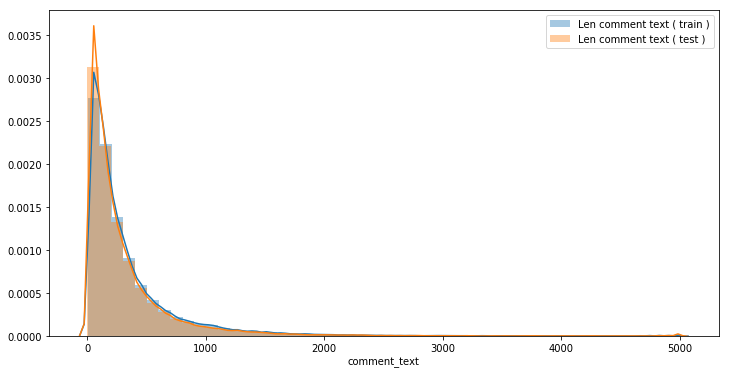

In [23]:
plt.figure(figsize=(12, 6))
sns.distplot(tr_len, label='Len comment text ( train )')
sns.distplot(te_len, label='Len comment text ( test )')
plt.legend(loc='best');

### Add a new column for clean comments

In [27]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Let's look at missing rows

In [26]:
train.comment_text.isnull().sum(), test.comment_text.isnull().sum()

(0, 0)

### Building the model

We'll start by creating a bag of words representation, as a term document matrix. We'll use ngrams, as suggested in the NBSVM paper.

In [29]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [32]:
%%time

n   = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

trn_term_doc  = vec.fit_transform(train['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

CPU times: user 59.8 s, sys: 1.88 s, total: 1min 1s
Wall time: 1min 1s


### Modelling

In [3]:
%%time

tokenizer  = WordPunctTokenizer()

trn_tokens = train['comment_text'].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))
te_tokens  = test['comment_text'].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))

CPU times: user 9.19 s, sys: 112 ms, total: 9.3 s
Wall time: 9.35 s


**Not all words are useful**

In [25]:
trn_token_counts = Counter(' '.join(trn_tokens).split(' '))
te_token_counts  = Counter(' '.join(te_tokens).split(' '))

In [26]:
print("Total unique tokens :", len(trn_token_counts))
print('\n'.join(map(str, trn_token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, trn_token_counts.most_common()[-3:])))

Total unique tokens : 195356
('.', 562729)
('the', 496796)
(',', 453829)
('to', 297408)
('i', 240405)
...
('956ce', 1)
('automakers', 1)
('ciu', 1)


Text(0.5, 0, 'Counts')

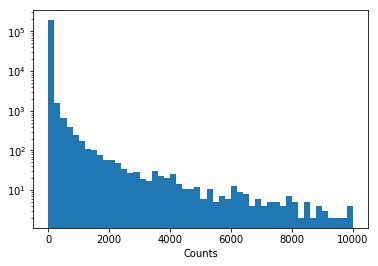

In [27]:
# Let's see how many words are there for each count

_=plt.hist(list(trn_token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

In [29]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = list(filter(lambda x: trn_token_counts[x] > min_count, trn_token_counts.keys()))

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens   = [UNK, PAD] + tokens

In [30]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 26170
Correct!


**Task 1.2 Build an inverse token index: a dictionary from token(string) to it's index in tokens (int)**

In [35]:
%%time

token_to_id = {}

for tok in tokens:
    if tok not in token_to_id:
        token_to_id[tok] = len(token_to_id)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 10.8 ms


In [36]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


**And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.**

In [38]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [39]:
print('\n'.join(train['comment_text'].iloc[:2].values), end='\n\n')
print("Matrix:")
print(as_matrix(train['comment_text'].iloc[:2]))

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)

Matrix:
[[ 0  0  4  5  6  7  8  9  0  0  0 13  0  0  0  0 22 23 24 25  0 27  0 29
  30  0  0  0  0  0 37  0 39  4 40 41  4 42 43 44  0 46  0]
 [ 0  0 56 57 58 59  0 60 61  0  0  0  0  0  0 71  0  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]]


**The data science part**

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

To be completely rigorous, we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [178]:
data_train, data_val = train_test_split(train, test_size=0.3, random_state=42)

# create target for clean comment
data_train.loc[:, 'clean'] = 1 - data_train.iloc[:, 2:].max(axis=1)
data_val.loc[:, 'clean']   = 1 - data_val.iloc[:, 2:].max(axis=1)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train size =  111699
Validation size =  47872


In [179]:
def pre_process(train):
    tokenizer  = WordPunctTokenizer()
    trn_tokens = train['comment_text'].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))
    trn_token_counts = Counter(' '.join(trn_tokens).split(' '))
    
    min_count = 10

    # tokens from token_counts keys that had at least min_count occurrences throughout the dataset
    tokens = list(filter(lambda x: trn_token_counts[x] > min_count, trn_token_counts.keys()))

    # Add a special tokens for unknown and empty words
    UNK, PAD = "UNK", "PAD"
    tokens   = [UNK, PAD] + tokens
    
    token_to_id = {}

    for tok in tokens:
        if tok not in token_to_id:
            token_to_id[tok] = len(token_to_id)
    
    return tokens, token_to_id

In [76]:
%%time

tokens, token_to_id = pre_process(data_train)

CPU times: user 6.56 s, sys: 144 ms, total: 6.71 s
Wall time: 6.71 s


In [77]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [104]:
text_col       = 'comment_text'
target_columns = data_train.columns.tolist()[2:]

In [105]:
def generate_batch(data, batch_size=None, replace=True, max_len=None, target_columns=[]):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    batch[text_col] = as_matrix(data[text_col].values, max_len)
    batch['target'] = data.loc[:, target_columns].values
    
    return batch

In [106]:
generate_batch(data_train, 3, max_len=10, target_columns=target_columns)

{'comment_text': array([[  245,     0,     0,  1431,    29,   655,    84,    90,   542,
           465],
        [    0,   883,    90, 17697,     6,     0,  2062,    27,    98,
          6355],
        [  245,     0,     0,     0,  3588,    29,     0,   354,  1311,
            29]], dtype=int32), 'target': array([[0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1]], dtype=int64)}

In [107]:
class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [108]:
class CommentsEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb   = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, 7)
    
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = F.relu(h)
        h = self.pool1(h)
        h = self.dense(h)
        
        return h

In [109]:
comment_encoder = CommentsEncoder(out_size=64)

dummy_x = torch.LongTensor(generate_batch(data_train, 3)['comment_text'])
dummy_v = comment_encoder(dummy_x)

assert tuple(dummy_v.shape) == (dummy_x.shape[0], 7)

del comment_encoder
print("Seems fine")

Seems fine


In [110]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    loss = nn.CrossEntropyLoss()
    return loss(reference, prediction)

In [155]:
# test on a single batch
batch           = generate_batch(data_train, 3, max_len=10, target_columns=target_columns)
comment_encoder = CommentsEncoder(out_size=64)

comments_ix = torch.LongTensor(batch['comment_text'])
targets     = batch['target'].argmax(axis=1)
reference   = torch.LongTensor(targets)

prediction  = comment_encoder(comments_ix)

assert len(prediction.shape) == 2 and prediction.shape[0] == comments_ix.shape[0]

In [116]:
loss        = compute_loss(prediction, reference)
dummy_grads = torch.autograd.grad(loss, comment_encoder.parameters(), retain_graph=True)

for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Training

In [180]:
from tqdm import tnrange

def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], 
                             max_len=max_len, target_columns=target_columns)

In [185]:
num_epochs = 10
max_len    = 200
batch_size = 32
batches_per_epoch = 100

In [186]:
def compute_loss(prediction, reference):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    loss = nn.CrossEntropyLoss()
    return loss(prediction, reference).cuda()

def compute_accuracy(reference, prediction):
    _, predicted = torch.max(prediction, 1)
    return (predicted == reference).squeeze().sum().item()

In [187]:
comment_encoder = CommentsEncoder(out_size=64).cuda()
opt             = torch.optim.Adam(comment_encoder.parameters(), lr=1e-3)

for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_batches = 0
    train_acc = 0
    total     = 0
    
    comment_encoder.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch, verbose=False):

        comments_ix = torch.LongTensor(batch['comment_text']).cuda()
        targets     = batch['target'].argmax(axis=1)
        reference   = torch.LongTensor(targets).cuda()

        prediction = comment_encoder(comments_ix)
        
        loss     = compute_loss(prediction, reference)
        accuracy = compute_accuracy(reference, prediction)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss += loss.cpu().detach().data.numpy()
        train_acc  += accuracy
        
        train_batches += 1
        total         += reference.size(0)
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tAcc:\t%.5f" % (train_acc / total))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_batches = 0
    val_acc  = 0
    total    = 0
    
    comment_encoder.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False, verbose=False):
        comments_ix = torch.LongTensor(batch['comment_text']).cuda()
        targets     = batch['target'].argmax(axis=1)
        reference   = torch.LongTensor(targets).cuda()

        prediction = comment_encoder(comments_ix)
        loss       = compute_loss(prediction, reference)
        accuracy   = compute_accuracy(reference, prediction)
        
        val_loss   += loss.cpu().detach().data.numpy()
        val_acc    += accuracy
        
        val_batches += 1
        total       += reference.size(0)
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tAcc:\t%.5f" % (val_acc / total))
    print('\n\n')

Training:
	Loss:	0.39530
	Acc:	0.89125



Validation:
	Loss:	0.33517
	Acc:	0.89844



Training:
	Loss:	0.32715
	Acc:	0.89125



Validation:
	Loss:	0.32621
	Acc:	0.89879



Training:
	Loss:	0.34029
	Acc:	0.89563



Validation:
	Loss:	0.31459
	Acc:	0.89952



Training:
	Loss:	0.30909
	Acc:	0.90063



Validation:
	Loss:	0.30087
	Acc:	0.90207



Training:
	Loss:	0.30034
	Acc:	0.90063



Validation:
	Loss:	0.29084
	Acc:	0.90450



Training:
	Loss:	0.27296
	Acc:	0.91187



Validation:
	Loss:	0.29291
	Acc:	0.90734



Training:
	Loss:	0.26604
	Acc:	0.91656



Validation:
	Loss:	0.27392
	Acc:	0.91101



Training:
	Loss:	0.25603
	Acc:	0.91625



Validation:
	Loss:	0.27295
	Acc:	0.91158



Training:
	Loss:	0.25279
	Acc:	0.92063



Validation:
	Loss:	0.26578
	Acc:	0.91571



Training:
	Loss:	0.27194
	Acc:	0.91687



Validation:
	Loss:	0.25435
	Acc:	0.91847



